In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [3]:
from astropy.io import ascii
import numpy as np
from astropy.table import vstack
import astropy.units as u
from astropy.coordinates import SkyCoord
import glob
from astropy.cosmology import WMAP9 as cosmo
import os

In [4]:
import matplotlib.pyplot as plt
# update matplotlib params for bigger font
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'mathtext.fontset': 'stix',
         'font.family': 'STIXGeneral'}
pylab.rcParams.update(params)

# some setup stuff

In [5]:
fwhm_dict = {}
fwhm_tab = ascii.read("../gama09/survey.tab")
for i in range(len(fwhm_tab)):
    fwhm_dict[fwhm_tab[i]["shotid"]] = fwhm_tab[i]["fwhm"]
print(fwhm_dict)

{'20191203_0000024': 2.333400011062622, '20191221_0000022': 2.0584444999694824, '20191203_0000025': 2.4426465034484863, '20191222_0000023': 1.6163480281829834, '20191221_0000023': 2.275479555130005, '20191224_0000024': 1.9810320138931274, '20191222_0000024': 1.4415520429611206, '20191229_0000023': 4.096991062164307, '20191231_0000024': 1.4881174564361572, '20200101_0000019': 1.9725099802017212, '20191231_0000025': 1.757524013519287, '20200101_0000020': 1.7696959972381592, '20200118_0000017': 2.7910571098327637, '20200215_0000016': 1.771815538406372, '20200119_0000018': 1.5838370323181152, '20200217_0000014': 3.0926320552825928, '20200124_0000016': 1.36302649974823, '20200217_0000015': 2.751936912536621, '20200119_0000019': 1.918149471282959, '20200225_0000016': 1.8747169971466064, '20200125_0000020': 2.162390947341919, '20200315_0000012': 2.48221492767334, '20200126_0000020': 1.7999999523162842}


In [6]:
fwhm_dict_own = {}
fwhm_tab_own = ascii.read("../gama09_old/fwhm_posterior_mean.tab")
for i in range(len(fwhm_tab_own)):
    fwhm_dict_own[fwhm_tab_own[i]["shotid"]] = fwhm_tab_own[i]["fwhm"]
print(fwhm_dict_own)

{'20200118_0000017': 2.7095160168092, '20200215_0000016': 1.7900101648657412, '20200119_0000018': 1.5402138565872936, '20200217_0000014': 2.93509006097173, '20200124_0000016': 1.360131899385956, '20200217_0000015': 2.7038267000881544, '20200119_0000019': 1.890440751403384, '20200225_0000016': 1.901633425362246, '20200125_0000020': 2.097983416434289, '20200315_0000012': 2.3751547746225556, '20200126_0000020': 1.7237362145941837, '20191203_0000024': 2.2921183583433473, '20191221_0000022': 1.9895606150569014, '20191203_0000025': 2.365964080203168, '20191222_0000023': 1.4967921290595874, '20191221_0000023': 2.052091736732942, '20191224_0000024': 1.9480505209681818, '20191222_0000024': 1.3928349204956023, '20191231_0000024': 1.4591330384152439, '20200101_0000019': 1.8436786419151578, '20191231_0000025': 1.6667195578374445, '20200101_0000020': 1.7588950398703433}


In [7]:
import get_interpolation as gi

In [8]:
pwd

'/home/idies/workspace/Temporary/maja/scratch/gama09'

In [9]:
basedir = '/home/idies/workspace/Temporary/maja/scratch/gama09'

In [10]:
psf_func = gi.get_psf_func('/home/idies/workspace/Temporary/maja/scratch/gama09')
powerlaw_func = gi.get_powerlaw_func('/home/idies/workspace/Temporary/maja/scratch/gama09')


In [11]:
def lae_profile_powerlaw(rs, fwhm, c1, c2, redshift):
        center_profile = c1 * psf_func([(fwhm, r) for r in rs])
        halo_profile = c2 * powerlaw_func([(fwhm, redshift, r) for r in rs])

        return center_profile + halo_profile



In [11]:
fiberarea = np.pi*0.75**2

In [12]:
TROUGHSUB = True

if TROUGHSUB:
    direc = 'troughsub'
    DIR_APX = '_troughsub'
else:
    direc = 'original'
    DIR_APX = ''

# individual LAEs

In [13]:
chain_dir = f"../gama09/cobaya-chains/LAEs_individual/{direc}/"
print(chain_dir)

../gama09/cobaya-chains/LAEs_individual/troughsub/


In [14]:
lae_info = ascii.read(os.path.join(basedir, "lae_info.tab"))

In [15]:
megachains = {}
for ff in glob.glob(chain_dir+"g*"):
    fin = glob.glob(ff+"/*.?.txt")
    if len(fin)==0:
        print(ff, " is empty.")
        continue
    chains = []
    for fi in fin:
        tmp = ascii.read(fi)
        chains.append(tmp[int(len(tmp)/3.):])
    megachains[ff.split("/")[-1]] = vstack(chains)

In [16]:
data_dir = "../gama09/lae_data_troughsub/"
r_plot = np.arange(0, 10, 0.1)
redshifts = {}
lae_tabs = {}
for key in list(megachains.keys()):
    print(key)
    lae_tab = ascii.read(data_dir+key+".dat")
    lae_tab['mask'] = np.array(lae_tab["mask"], dtype=bool)
    field, ifu, id = key.split("_")
    linf = lae_info[(lae_info["field"]==field)&(np.array(lae_info["ifu"], dtype=int)==int(ifu))&(np.array(lae_info["id"], dtype=int)==int(id))][0]
    mid_ra, mid_dec = linf["ra_com"], linf["dec_com"]
    mid_wave = linf["wl_com"]
    redshift = mid_wave/1215.67 - 1
    redshifts[key] = redshift
    mid_coords = SkyCoord(ra=mid_ra*u.deg, dec=mid_dec*u.deg)
    lae_tab["r"] = mid_coords.separation(SkyCoord(ra=lae_tab["ra"]*u.deg, dec=lae_tab["dec"]*u.deg)).arcsec
    lae_tabs[key] = lae_tab
    continue
    
    plt.figure()
    for shotid in np.unique(lae_tab["shotid"]):
        if fwhm_dict[shotid] > 1.8:
            continue
        plt.errorbar(lae_tab[lae_tab["shotid"]==shotid]["r"], lae_tab[lae_tab["shotid"]==shotid]["flux"]/fiberarea, yerr=lae_tab[lae_tab["shotid"]==shotid]["flux_error"]/fiberarea, fmt=".")
    plt.plot(r_plot, lae_profile_powerlaw(rs=r_plot, fwhm=1.5, c1=np.nanmean(megachains[key]["c1"]), c2=np.nanmean(megachains[key]["c2"]),  redshift=redshift))
    

gama09E_104_45
gama09E_106_34
gama09E_16_143
gama09E_23_195
gama09E_24_60
gama09E_24_66
gama09E_28_67
gama09E_33_41
gama09E_33_7
gama09E_34_51
gama09E_35_24
gama09E_35_52
gama09E_36_199
gama09E_36_50
gama09E_43_23
gama09E_44_28
gama09E_46_40
gama09E_47_33
gama09E_47_72
gama09E_68_27
gama09E_68_35
gama09E_72_131
gama09E_75_62
gama09E_77_48
gama09E_83_62
gama09E_84_135
gama09E_84_34
gama09E_85_41
gama09E_86_217
gama09E_88_28
gama09E_94_94
gama09E_95_49
gama09E_97_101
gama09F_105_203
gama09F_106_125
gama09F_106_31
gama09F_13_47
gama09F_14_113
gama09F_16_34
gama09F_24_98
gama09F_27_87
gama09F_34_170
gama09F_37_121
gama09F_37_332
gama09F_38_88
gama09F_42_72
gama09F_43_197
gama09F_44_62
gama09F_44_63
gama09F_45_107
gama09F_53_192
gama09F_67_98
gama09F_76_199
gama09F_77_136
gama09F_81_68
gama09F_82_84
gama09F_87_131
gama09F_87_384
gama09F_87_418
gama09F_87_85
gama09F_91_52
gama09F_97_318
gama09F_98_436


In [17]:
if False:
    for key in lae_tabs.keys():
        plt.figure(figsize=(5,5))
        plt.plot(lae_tabs[key]['r'], lae_tabs[key]['flux_troughsub'], '.')
        plt.plot(lae_tabs[key]['r'][np.array(lae_tabs[key]['mask'], dtype=bool)], lae_tabs[key]['flux'][np.array(lae_tabs[key]['mask'], dtype=bool)], '.')

In [18]:
c1s_min, c1s_max, c1s_mid = [np.nanpercentile(mc["c1"], 16) for mc  in megachains.values()], [np.nanpercentile(mc["c1"], 100-16) for mc  in megachains.values()], [np.nanmedian(mc["c1"]) for mc  in megachains.values()]
c2s_min, c2s_max, c2s_mid = [np.nanpercentile(mc["c2"], 16) for mc  in megachains.values()], [np.nanpercentile(mc["c2"], 100-16) for mc  in megachains.values()], [np.nanmedian(mc["c2"]) for mc  in megachains.values()]
redshift_mask = [redshifts[key]<=2.6 for key in megachains.keys()]

c1s_min, c1s_max, c1s_mid = np.array(c1s_min), np.array(c1s_max), np.array(c1s_mid)
c2s_min, c2s_max, c2s_mid = np.array(c2s_min), np.array(c2s_max), np.array(c2s_mid)

median_c1s = np.nanmedian(c1s_mid)
median_c1s_err = np.nanstd(c1s_mid)/np.sqrt(len(c1s_mid))
median_c2s = np.nanmedian(c2s_mid)
median_c2s_err = np.nanstd(c2s_mid)/np.sqrt(len(c2s_mid))

mean_c1s = np.nanmean(c1s_mid)
mean_c1s_err = np.nanstd(c1s_mid)/np.sqrt(len(c1s_mid))
mean_c2s = np.nanmean(c2s_mid)
mean_c2s_err = np.nanstd(c2s_mid)/np.sqrt(len(c2s_mid))

median_c1s_lowz = np.nanmedian(c1s_mid[redshift_mask])
median_c1s_err_lowz = np.nanstd(c1s_mid[redshift_mask])/np.sqrt(len(c1s_mid[redshift_mask]))
median_c2s_lowz = np.nanmedian(c2s_mid[redshift_mask])
median_c2s_err_lowz = np.nanstd(c2s_mid[redshift_mask])/np.sqrt(len(c2s_mid[redshift_mask]))

mean_c1s_lowz = np.nanmean(c1s_mid[redshift_mask])
mean_c1s_err_lowz = np.nanstd(c1s_mid[redshift_mask])/np.sqrt(len(c1s_mid[redshift_mask]))
mean_c2s_lowz = np.nanmean(c2s_mid[redshift_mask])
mean_c2s_err_lowz = np.nanstd(c2s_mid[redshift_mask])/np.sqrt(len(c2s_mid[redshift_mask]))


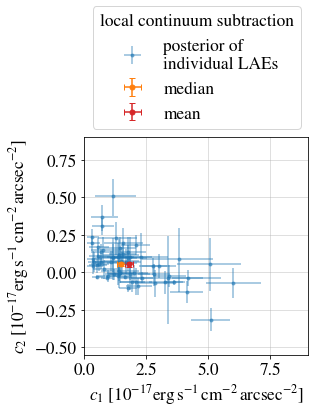

In [21]:
plt.figure(figsize=(4,4))

plt.errorbar(c1s_mid, c2s_mid, xerr=[c1s_mid-c1s_min, c1s_max-c1s_mid], yerr=[c2s_mid-c2s_min, c2s_max-c2s_mid], fmt=".", color="tab:blue", label=r"""posterior of
individual LAEs""", alpha=0.5)
#plt.errorbar(c1s_mid[redshift_mask], c2s_mid[redshift_mask], xerr=[c1s_mid[redshift_mask]-c1s_min[redshift_mask], c1s_max[redshift_mask]-c1s_mid[redshift_mask]], 
#             yerr=[c2s_mid[redshift_mask]-c2s_min[redshift_mask], c2s_max[redshift_mask]-c2s_mid[redshift_mask]], fmt=".", color="tab:blue", label=r"individual LAEs ($1.9\leq z\leq 2.6$)", alpha=0.5)

plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="tab:orange", label="median", capsize=3, markersize=5)
plt.errorbar(mean_c1s, mean_c2s, xerr=mean_c1s_err, yerr=mean_c2s_err,
             fmt="o", color="tab:red", label="mean", capsize=3, markersize=5)

plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")

if TROUGHSUB:
    title = 'local continuum subtraction'
else:
    title = None
plt.legend(bbox_to_anchor=[0, 1], loc='lower left', title=title, title_fontsize='xx-large')
plt.grid(alpha=0.5)
plt.xlim(0, 9)
plt.ylim(-0.55, 0.9)
#plt.savefig("thesis_plots/gama_individual_laes_posterior_troughsub.pdf", bbox_inches="tight")

In [76]:
np.nanmin(c2s_mid), np.nanmax(c2s_mid), len(c2s_mid[c2s_mid<0]), len(c2s_mid[c2s_mid>0]), 18+45

(-0.31616386, 0.50935588, 25, 38, 63)

In [77]:
print('Troughsub? ', TROUGHSUB)
print('median c1s: ', median_c1s, '\pm', median_c1s_err)
print('median c2s: ', median_c2s, '\pm', median_c2s_err)

print('\nmean c1s: ', mean_c1s, '\pm', mean_c1s_err)
print('mean c2s: ', mean_c2s, '\pm', mean_c2s_err)

print('\nlow redshift (z<2.6):')
print('median c1s: ', median_c1s_lowz, '\pm', median_c1s_err_lowz)
print('median c2s: ', median_c2s_lowz, '\pm', median_c2s_err_lowz)

Troughsub?  True
median c1s:  1.4636745 \pm 0.1597246152087638
median c2s:  0.0561801895 \pm 0.015568307084438664

mean c1s:  1.8112832239682544 \pm 0.1597246152087638
mean c2s:  0.0541787677 \pm 0.015568307084438664

low redshift (z<2.6):
median c1s:  1.401315225 \pm 0.19606150408509768
median c2s:  0.07898292800000001 \pm 0.020007705221120234


# all LAEs ($\sigma_\mathrm{int}=0$)

In [78]:
chain_dir = f"../gama09/cobaya-chains/LAEs_all/{direc}/zero_sigma_int/all_z/"
print(chain_dir)
all_laes_chain = []
for fin in glob.glob(chain_dir+"*.?.txt"):
    tmp = ascii.read(fin)
    all_laes_chain.append(tmp[int(len(tmp)/3.):])
    
all_laes_chain = vstack(all_laes_chain)

../gama09/cobaya-chains/LAEs_all/troughsub/zero_sigma_int/all_z/


In [79]:
mid_all_c1, min_all_c1, max_all_c1 = np.nanmedian(all_laes_chain["c1"]), np.nanpercentile(all_laes_chain["c1"], 16), np.nanpercentile(all_laes_chain["c1"], 100-16)
mid_all_c2, min_all_c2, max_all_c2 = np.nanmedian(all_laes_chain["c2"]), np.nanpercentile(all_laes_chain["c2"], 16), np.nanpercentile(all_laes_chain["c2"], 100-16)

In [80]:
print('mid c1: ', mid_all_c1, min_all_c1, max_all_c1)
print('mid c2: ', mid_all_c2, min_all_c2, max_all_c2)

mid c1:  1.8368024 1.785425552 1.890869588
mid c2:  -0.061279115 -0.06538767052 -0.05723457068


In [81]:
h, xedges, yedges = np.histogram2d(all_laes_chain["c1"], all_laes_chain["c2"], bins=(np.arange(1.5, 3.5, 0.05), np.arange(-0.1, 0.19, 0.005)))

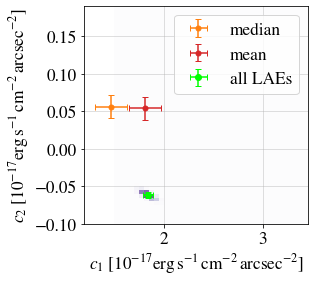

In [82]:
plt.figure(figsize=(4,4))
plt.imshow(h.T[::-1], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', zorder=0, cmap='Purples', alpha=0.7)

#plt.plot(all_laes_chain["c1"], all_laes_chain["c2"], ".", alpha=0.1, zorder=10, label="chain all LAEs", color='white')
plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="tab:orange", label="median", capsize=3, markersize=5)
plt.errorbar(mean_c1s, mean_c2s, xerr=mean_c1s_err, yerr=mean_c2s_err,
             fmt="o", color="tab:red", label="mean", capsize=3, markersize=5)

plt.errorbar(mid_all_c1, mid_all_c2, xerr=[[mid_all_c1-min_all_c1], [max_all_c1-mid_all_c1]], yerr=[[mid_all_c2-min_all_c2], [max_all_c2-mid_all_c2]],
             fmt="o", zorder=1, capsize=3, color="lime", label="all LAEs")

plt.legend(bbox_to_anchor=[1.,1])
plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.grid(alpha=0.5)

#plt.figure(figsize=(4,4))
#plt.imshow(h[::-1].T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')

# all LAEs ($\sigma_\mathrm{int} \neq 0$)

In [83]:
# sigma_int = 0.08224597796595344 (Planck18)
# sigma_int (troughsub) = 0.09562446908472819 (Planck18)

../gama09/cobaya-chains/LAEs_all/troughsub/sigma_int/all_z/


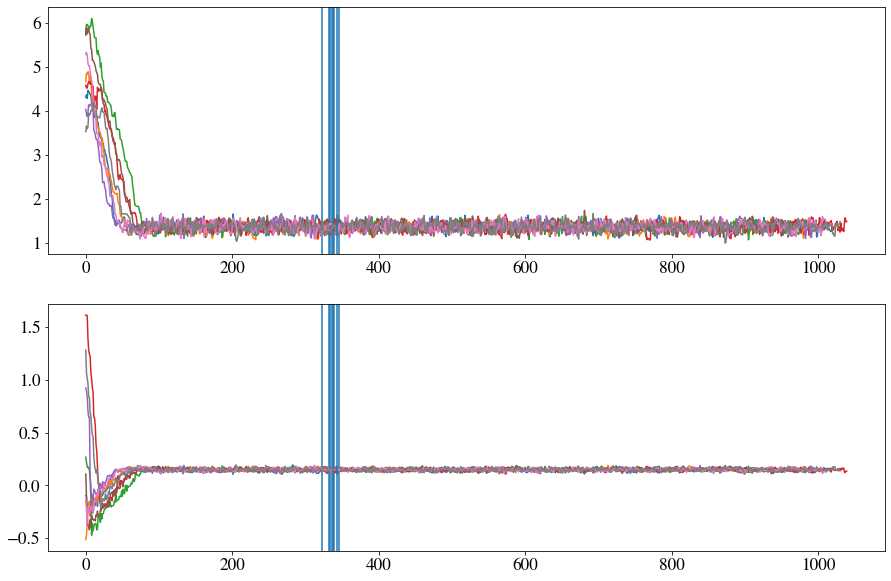

In [84]:
chain_dir = f"../gama09/cobaya-chains/LAEs_all/{direc}/sigma_int/all_z/"
print(chain_dir)
all_laes_chain_s = []
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for fin in glob.glob(chain_dir+"*.?.txt"):
    tmp = ascii.read(fin)
    ax1.plot(tmp["c1"])
    ax2.plot(tmp["c2"])
    ax1.axvline(int(len(tmp)/3.))
    ax2.axvline(int(len(tmp)/3.))
    all_laes_chain_s.append(tmp[int(len(tmp)/3.):])
    
all_laes_chain_s = vstack(all_laes_chain_s)

In [85]:
mid_all_c1_s, min_all_c1_s, max_all_c1_s = np.nanmedian(all_laes_chain_s["c1"]), np.nanpercentile(all_laes_chain_s["c1"], 16), np.nanpercentile(all_laes_chain_s["c1"], 100-16)
mid_all_c2_s, min_all_c2_s, max_all_c2_s = np.nanmedian(all_laes_chain_s["c2"]), np.nanpercentile(all_laes_chain_s["c2"], 16), np.nanpercentile(all_laes_chain_s["c2"], 100-16)

In [86]:
print('troughsub? ', TROUGHSUB)
print('mid all c1s: ', mid_all_c1_s, min_all_c1_s, max_all_c1_s)
print('mid all c2s: ', mid_all_c2_s, min_all_c2_s, max_all_c2_s)

troughsub?  True
mid all c1s:  1.3790877 1.2771499400000002 1.47464504
mid all c2s:  0.15006151 0.136555046 0.163533664


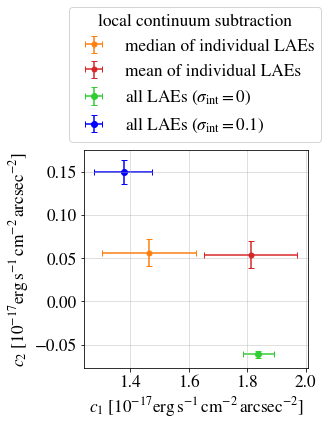

In [88]:
plt.figure(figsize=(4,4))

h, xedges, yedges = np.histogram2d(all_laes_chain_s["c1"], all_laes_chain_s["c2"], bins=(np.arange(1., 3.5, 0.05), np.arange(-0.1, 0.22, 0.005)))
#plt.imshow(h.T[::-1], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', zorder=0, cmap='Purples', alpha=0.7)

#plt.plot(all_laes_chain_s["c1"], all_laes_chain_s["c2"], ".", alpha=0.1, zorder=0, label="chain all LAEs")
plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="tab:orange", label="median of individual LAEs", capsize=3, markersize=5)
plt.errorbar(mean_c1s, mean_c2s, xerr=mean_c1s_err, yerr=mean_c2s_err,
             fmt="o", color="tab:red", label="mean of individual LAEs", capsize=3, markersize=5)

plt.errorbar(mid_all_c1, mid_all_c2, xerr=[[mid_all_c1-min_all_c1], [max_all_c1-mid_all_c1]], yerr=[[mid_all_c2-min_all_c2], [max_all_c2-mid_all_c2]],
             fmt="o", zorder=1, capsize=3, color="limegreen", label=r"all LAEs ($\sigma_\mathrm{int}=0$)")

plt.errorbar(mid_all_c1_s, mid_all_c2_s, xerr=[[mid_all_c1_s-min_all_c1_s], [max_all_c1_s-mid_all_c1_s]], yerr=[[mid_all_c2_s-min_all_c2_s], [max_all_c2_s-mid_all_c2_s]],
             fmt="o", zorder=1, capsize=3, color="blue", label="all LAEs ($\sigma_\mathrm{int} = 0.1$)")

plt.legend(bbox_to_anchor=[1.1,1], loc='lower right', title='local continuum subtraction', title_fontsize='xx-large')
plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.grid(alpha=0.5)

#plt.savefig('thesis_plots/gama_compare_results_troughsub.pdf',bbox_inches='tight')

# low-z LAEs ($\sigma_\mathrm{int}=0$, $1.9\leq z \leq 2.6$)

In [39]:
chain_dir = "../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/"
lowz_laes_chain = []
for fin in glob.glob(chain_dir+"*.?.txt"):
    print(fin)
    tmp = ascii.read(fin)
    lowz_laes_chain.append(tmp[int(len(tmp)/3.):])
    
lowz_laes_chain = vstack(lowz_laes_chain)

../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.2.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.7.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.6.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.8.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.1.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.4.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.3.txt
../gama09/cobaya-chains/LAEs_all/original/zero_sigma_int/low_z/all.5.txt


In [40]:
mid_low_c1, min_low_c1, max_low_c1 = np.nanmedian(lowz_laes_chain["c1"]), np.nanpercentile(lowz_laes_chain["c1"], 16), np.nanpercentile(lowz_laes_chain["c1"], 100-16)
mid_low_c2, min_low_c2, max_low_c2 = np.nanmedian(lowz_laes_chain["c2"]), np.nanpercentile(lowz_laes_chain["c2"], 16), np.nanpercentile(lowz_laes_chain["c2"], 100-16)

In [41]:
print('mid low-z c1: ', mid_low_c1, min_low_c1, max_low_c1)
print('mid low-z c2: ', mid_low_c2, min_low_c2, max_low_c2)

mid low-z c1:  2.33810445 2.205986608 2.4757472719999996
mid low-z c2:  0.12454964 0.10452515080000001 0.14502973200000002


Text(0, 0.5, '$c_2\\,\\, [10^{-17}\\mathrm{erg/s/cm}^2/\\mathrm{arcsec}^2]$')

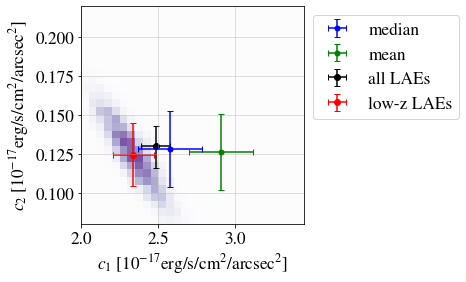

In [42]:
plt.figure(figsize=(4,4))

h, xedges, yedges = np.histogram2d(lowz_laes_chain["c1"], lowz_laes_chain["c2"], bins=(np.arange(2.0, 3.5, 0.05), np.arange(0.08, 0.22, 0.005)))
plt.imshow(h.T[::-1], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', zorder=0, cmap='Purples', alpha=0.7)

#plt.plot(lowz_laes_chain["c1"], lowz_laes_chain["c2"], ".", alpha=0.1, zorder=0, color="tab:blue", label="chain low-z LAEs")
plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="blue", label="median", capsize=3, markersize=5)
plt.errorbar(mean_c1s, mean_c2s, xerr=mean_c1s_err, yerr=mean_c2s_err,
             fmt="o", color="green", label="mean", capsize=3, markersize=5)

plt.errorbar(mid_all_c1, mid_all_c2, xerr=[[mid_all_c1-min_all_c1], [max_all_c1-mid_all_c1]], yerr=[[mid_all_c2-min_all_c2], [max_all_c2-mid_all_c2]],
             fmt="o", zorder=1, capsize=3, color="black", label="all LAEs")

plt.errorbar(mid_low_c1, mid_low_c2, xerr=[[mid_low_c1-min_low_c1], [max_low_c1-mid_low_c1]], yerr=[[mid_low_c2-min_low_c2], [max_low_c2-mid_low_c2]],
             fmt="o", zorder=1, capsize=3, color="red", label="low-z LAEs")

plt.legend(bbox_to_anchor=[1,1])
plt.grid(alpha=0.5)
plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg/s/cm}^2/\mathrm{arcsec}^2]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg/s/cm}^2/\mathrm{arcsec}^2]$")

# low-z LAEs ($\sigma_\mathrm{int}\neq0$, $1.9\leq z \leq 2.6$)

In [43]:
# sigma_int = 0.09190385807835204 (Planck18)

cobaya-chains/LAEs_all/original/sigma_int/low_z/all.1.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.2.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.3.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.4.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.5.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.6.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.7.txt
cobaya-chains/LAEs_all/original/sigma_int/low_z/all.8.txt


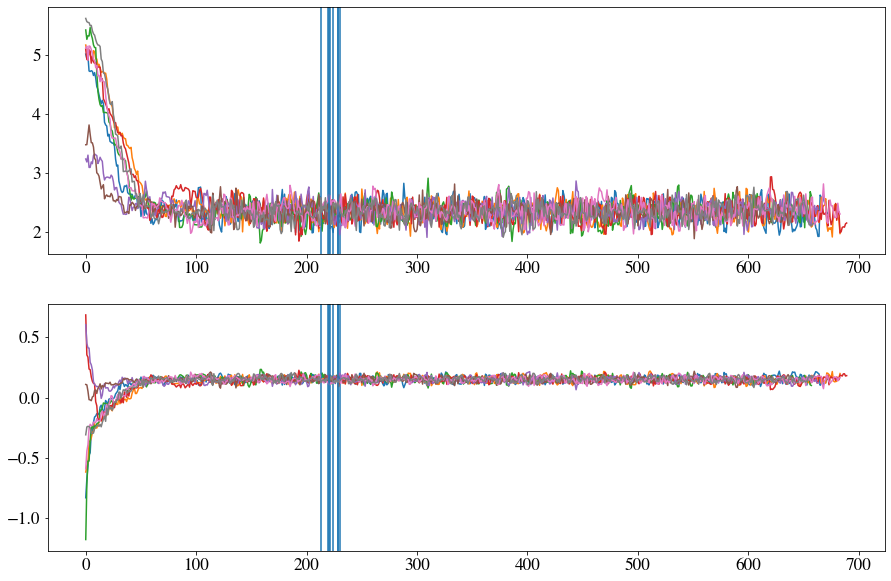

In [44]:
chain_dir = "cobaya-chains/LAEs_all/original/sigma_int/low_z/"
lowz_laes_chain_s = []

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for fin in glob.glob(chain_dir+"*.?.txt"):
    print(fin)
    tmp = ascii.read(fin)
    ax1.plot(tmp["c1"])
    ax2.plot(tmp["c2"])
    ax1.axvline(int(len(tmp)/3.))
    ax2.axvline(int(len(tmp)/3.))
    lowz_laes_chain_s.append(tmp[int(len(tmp)/3.):])
    
lowz_laes_chain_s = vstack(lowz_laes_chain_s)

In [45]:
mid_low_c1_s, min_low_c1_s, max_low_c1_s = np.nanmedian(lowz_laes_chain_s["c1"]), np.nanpercentile(lowz_laes_chain_s["c1"], 16), np.nanpercentile(lowz_laes_chain_s["c1"], 100-16)
mid_low_c2_s, min_low_c2_s, max_low_c2_s = np.nanmedian(lowz_laes_chain_s["c2"]), np.nanpercentile(lowz_laes_chain_s["c2"], 16), np.nanpercentile(lowz_laes_chain_s["c2"], 100-16)

In [46]:
print('mid c1s: ', mid_low_c1_s, min_low_c1_s, max_low_c1_s)
print('mid c2s: ', mid_low_c2_s, min_low_c2_s, max_low_c2_s)

mid c1s:  2.3406012 2.18039724 2.49796344
mid c2s:  0.15031836 0.125526404 0.174529684


Text(0, 0.5, '$c_2\\,\\, [10^{-17}\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{arcsec}^{-2}]$')

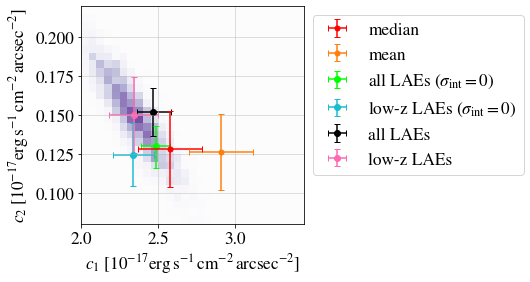

In [48]:
plt.figure(figsize=(4,4))

h, xedges, yedges = np.histogram2d(lowz_laes_chain_s["c1"], lowz_laes_chain_s["c2"], bins=(np.arange(2.0, 3.5, 0.05), np.arange(0.08, 0.22, 0.005)))
plt.imshow(h.T[::-1], extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', zorder=0, cmap='Purples', alpha=0.7)

#plt.plot(lowz_laes_chain_s["c1"], lowz_laes_chain_s["c2"], ".", alpha=0.1, zorder=0, color="tab:blue", label="chain low-z LAEs")

plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="red", label="median", capsize=3, markersize=5)
plt.errorbar(mean_c1s, mean_c2s, xerr=mean_c1s_err, yerr=mean_c2s_err,
             fmt="o", color="tab:orange", label="mean", capsize=3, markersize=5)

plt.errorbar(mid_all_c1, mid_all_c2, xerr=[[mid_all_c1-min_all_c1], [max_all_c1-mid_all_c1]], yerr=[[mid_all_c2-min_all_c2], [max_all_c2-mid_all_c2]],
             fmt="o", zorder=1, capsize=3, color="lime", label=r"all LAEs ($\sigma_\mathrm{int}=0$)")

plt.errorbar(mid_low_c1, mid_low_c2, xerr=[[mid_low_c1-min_low_c1], [max_low_c1-mid_low_c1]], yerr=[[mid_low_c2-min_low_c2], [max_low_c2-mid_low_c2]],
             fmt="o", zorder=1, capsize=3, color="tab:cyan", label=r"low-z LAEs ($\sigma_\mathrm{int}=0$)")

plt.errorbar(mid_all_c1_s, mid_all_c2_s, xerr=[[mid_all_c1_s-min_all_c1_s], [max_all_c1_s-mid_all_c1_s]], yerr=[[mid_all_c2_s-min_all_c2_s], [max_all_c2_s-mid_all_c2_s]],
             fmt="o", zorder=1, capsize=3, color="black", label="all LAEs")

plt.errorbar(mid_low_c1_s, mid_low_c2_s, xerr=[[mid_low_c1_s-min_low_c1_s], [max_low_c1_s-mid_low_c1_s]], yerr=[[mid_low_c2_s-min_low_c2_s], [max_low_c2_s-mid_low_c2_s]],
             fmt="o", zorder=1, capsize=3, color="hotpink", label="low-z LAEs")

plt.legend(bbox_to_anchor=[1,1], loc='upper left')
plt.grid(alpha=0.5)
plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")

# star halos

In [49]:
flag_more = """F_faint_3
F_faint_6
F_faint_24
E_faint_36
E_faint_23
E_faint_15
E_faint_4
E_faint_28
F_faint_41
E_faint_14
F_faint_25
F_faint_20
E_faint_18""".split("\n")

In [50]:
chain_dir = "../gama09/cobaya-chains/star_halo/*faint*"
star_chains = {}
for ff in glob.glob(chain_dir):
    key = ff.split("/")[-1]
    if key in flag_more:
        continue
    chains = []
    for fin in glob.glob(ff+"/*.?.txt"):
        tmp = ascii.read(fin)
        chains.append(tmp[int(len(tmp)/3.):])
    star_chains[key] = vstack(chains)

In [51]:
c1s_min_st, c1s_max_st, c1s_mid_st = [np.nanpercentile(mc["c1"], 16) for mc  in star_chains.values()], [np.nanpercentile(mc["c1"], 100-16) for mc  in star_chains.values()], [np.nanmedian(mc["c1"]) for mc  in star_chains.values()]
c2s_min_st, c2s_max_st, c2s_mid_st = [np.nanpercentile(mc["c2"], 16) for mc  in star_chains.values()], [np.nanpercentile(mc["c2"], 100-16) for mc  in star_chains.values()], [np.nanmedian(mc["c2"]) for mc  in star_chains.values()]

c1s_min_st, c1s_max_st, c1s_mid_st = np.array(c1s_min_st), np.array(c1s_max_st), np.array(c1s_mid_st)
c2s_min_st, c2s_max_st, c2s_mid_st = np.array(c2s_min_st), np.array(c2s_max_st), np.array(c2s_mid_st)

median_c1s_st = np.nanmedian(c1s_mid_st)
median_c1s_err_st = np.nanstd(c1s_mid_st)/np.sqrt(len(c1s_mid_st))
median_c2s_st = np.nanmedian(c2s_mid_st)
median_c2s_err_st = np.nanstd(c2s_mid_st)/np.sqrt(len(c2s_mid_st))

mean_c1s_st = np.nanmean(c1s_mid_st)
mean_c1s_err_st = np.nanstd(c1s_mid_st)/np.sqrt(len(c1s_mid_st))
mean_c2s_st = np.nanmean(c2s_mid_st)
mean_c2s_err_st = np.nanstd(c2s_mid_st)/np.sqrt(len(c2s_mid_st))


In [52]:
for i in range(len(list(star_chains.keys()))):
    key = list(star_chains.keys())[i]
    if key in flag_more:
        continue
    if (c1s_mid_st[i] < 9):
        print(key)

E_faint_1
E_faint_11
E_faint_16
E_faint_2
E_faint_20
E_faint_22
E_faint_24
E_faint_27
E_faint_29
E_faint_30
E_faint_31
E_faint_32
E_faint_34
E_faint_37
E_faint_5
E_faint_7
E_faint_9
F_faint_14
F_faint_15
F_faint_16
F_faint_17
F_faint_2
F_faint_22
F_faint_23
F_faint_26
F_faint_30
F_faint_31
F_faint_33
F_faint_34
F_faint_35
F_faint_36
F_faint_40
F_faint_42
F_faint_5


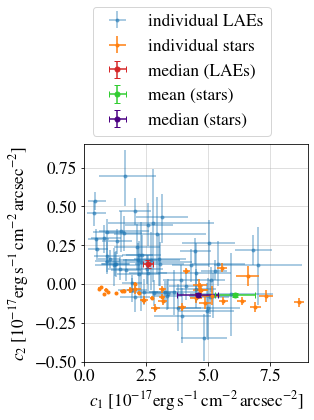

In [54]:
plt.figure(figsize=(4,4))

plt.errorbar(c1s_mid, c2s_mid, xerr=[c1s_mid-c1s_min, c1s_max-c1s_mid], yerr=[c2s_mid-c2s_min, c2s_max-c2s_mid], fmt=".", color="tab:blue", label=r"individual LAEs", alpha=0.5)
plt.errorbar(c1s_mid_st, c2s_mid_st, xerr=[c1s_mid_st-c1s_min_st, c1s_max_st-c1s_mid_st], yerr=[c2s_mid_st-c2s_min_st, c2s_max_st-c2s_mid_st], fmt=".", 
             color="tab:orange", label=r"individual stars", alpha=1)
#for i in range(len(c1s_mid_st)):
#    if (c1s_mid_st[i] < 9)&(c2s_mid_st[i]>0):
#        plt.text(c1s_mid_st[i], c2s_mid_st[i]+0.01, list(star_chains.keys())[i], fontsize=12, rotation=45)

plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="tab:red", label="median (LAEs)", capsize=3, markersize=5)
plt.errorbar(mean_c1s_st, mean_c2s_st, xerr=mean_c1s_err_st, yerr=mean_c2s_err_st,
             fmt="o", color="limegreen", label="mean (stars)", capsize=3, markersize=5)
plt.errorbar(median_c1s_st, median_c2s_st, xerr=median_c1s_err_st, yerr=median_c2s_err_st,
             fmt="o", color="indigo", label="median (stars)", capsize=3, markersize=5)

plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.legend(bbox_to_anchor=(0, 1.), loc='lower left')#, loc='upper left')
plt.grid(alpha=0.5)
plt.xlim(0, 9)
plt.ylim(-0.5, 0.9)
#plt.savefig("thesis_plots/gama_star_halos_laes_comparison.pdf", bbox_inches="tight")

# compare different results

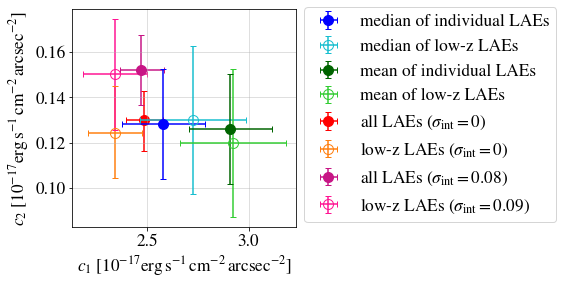

In [56]:
plt.figure(figsize=(4,4))

plt.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="blue", label="median of individual LAEs", capsize=3, markersize=10)

plt.errorbar(median_c1s_lowz, median_c2s_lowz, xerr=median_c1s_err_lowz, yerr=median_c2s_err_lowz,
             fmt="o", mfc="none", color="tab:cyan", label="median of low-z LAEs", capsize=3, markersize=10)

plt.errorbar(mean_c1s, mean_c2s, xerr=mean_c1s_err, yerr=mean_c2s_err,
             fmt="o", color="darkgreen", label="mean of individual LAEs", capsize=3, markersize=10)

plt.errorbar(mean_c1s_lowz, mean_c2s_lowz, xerr=mean_c1s_err_lowz, yerr=mean_c2s_err_lowz,
             fmt="o", mfc="none", color="limegreen", label="mean of low-z LAEs", capsize=3, markersize=10)

plt.errorbar(mid_all_c1, mid_all_c2, xerr=[[mid_all_c1-min_all_c1], [max_all_c1-mid_all_c1]], yerr=[[mid_all_c2-min_all_c2], [max_all_c2-mid_all_c2]],
             fmt="o", zorder=1, capsize=3, color="red", label=r"all LAEs ($\sigma_\mathrm{int}=0$)", markersize=10)

plt.errorbar(mid_low_c1, mid_low_c2, xerr=[[mid_low_c1-min_low_c1], [max_low_c1-mid_low_c1]], yerr=[[mid_low_c2-min_low_c2], [max_low_c2-mid_low_c2]],
             fmt="o", mfc="none", zorder=1, capsize=3, color="tab:orange", label=r"low-z LAEs ($\sigma_\mathrm{int}=0$)", markersize=10)

plt.errorbar(mid_all_c1_s, mid_all_c2_s, xerr=[[mid_all_c1_s-min_all_c1_s], [max_all_c1_s-mid_all_c1_s]], yerr=[[mid_all_c2_s-min_all_c2_s], [max_all_c2_s-mid_all_c2_s]],
             fmt="o", zorder=1, capsize=3, color="mediumvioletred", label=r"all LAEs ($\sigma_\mathrm{int}=0.08$)", markersize=10)

plt.errorbar(mid_low_c1_s, mid_low_c2_s, xerr=[[mid_low_c1_s-min_low_c1_s], [max_low_c1_s-mid_low_c1_s]], yerr=[[mid_low_c2_s-min_low_c2_s], [max_low_c2_s-mid_low_c2_s]],
             fmt="o", zorder=1, mfc="none", capsize=3, color="deeppink", label=r"low-z LAEs ($\sigma_\mathrm{int}=0.09$)", markersize=10)

plt.legend(bbox_to_anchor=(1, 1.05), loc='upper left')
plt.xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.ylabel(r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
plt.grid(alpha=0.5)

#plt.savefig("thesis_plots/gama_compare_final_results.pdf", bbox_inches="tight")

# stack LAEs and compare with Chris

In [17]:
chris_profiles = {}
for cp in glob.glob('/home/idies/workspace/Temporary/maja/scratch/chris_profiles/chris_profiles_extended_individual*.tab'):
    tmp = cp.split('_')
    fwhm = float(tmp[-3])
    mass_min = float(tmp[-2])
    mass_max = float(tmp[-1][:-4])
    print(fwhm, mass_min, mass_max)
    chris_profiles[(fwhm, mass_min, mass_max)] = ascii.read(cp)

1.62 9.5 10.0
1.62 10.0 10.5
1.62 10.5 11.0
1.36 9.5 10.0
1.36 10.0 10.5
1.36 10.5 11.0
1.8 9.5 10.0
1.8 10.0 10.5
1.8 10.5 11.0


In [18]:
r_diff = 5
r_bins = np.arange(0, 90, r_diff)
r_bins_max = r_bins + r_diff
r_bins_plot = r_bins + r_diff/2.

r_bins_kpc = np.array([0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70])
r_bins_max_kpc = np.array([5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80])
delta_r_kpc = (r_bins_max_kpc - r_bins_kpc)/2.

r_bins_plot = np.nanmean([r_bins_kpc, r_bins_max_kpc], axis=0)

r_psf = np.arange(1e-15, 80, 0.1)

In [19]:
stack_median = []
stack_median_error = []
stack_median_troughsub = []
stack_median_error_troughsub = []
stack_mean_troughsub = []
stack_mean_error_troughsub = []
fwhms_all = []
for r_min, r_max in zip(r_bins_kpc, r_bins_max_kpc):
    tmp = []
    for key in lae_tabs.keys():
        redshift = redshifts[key]
        #if redshift > 2.6:
        #   continue
        lae_tab = lae_tabs[key]
        lae_tab = lae_tab[(lae_tab['flux']!=0)&(lae_tab['flux_troughsub']!=0)]
        fwhms = np.array([fwhm_dict[shotid] for shotid in lae_tab["shotid"]])
        rs_kpc = lae_tab["r"]*cosmo.kpc_proper_per_arcmin(redshift)/60*u.arcmin/u.kpc
        here = (rs_kpc >= r_min) & (rs_kpc < r_max) & (fwhms <= 1.8) & (lae_tab['mask'])
        tmp.append(lae_tab['flux'][here]/fiberarea)
        fwhms_all.append(fwhms[here])
        
    tmp = np.concatenate(tmp)
    stack_median.append(np.nanmedian(tmp))
    stack_median_error.append(np.nanstd(tmp)/np.sqrt(len(tmp)))
    
    tmp = []
    for key in lae_tabs.keys():
        redshift = redshifts[key]
        #if redshift > 2.6:
        #   continue
        lae_tab = lae_tabs[key]
        lae_tab = lae_tab[(lae_tab['flux']!=0)&(lae_tab['flux_troughsub']!=0)]
        fwhms = np.array([fwhm_dict[shotid] for shotid in lae_tab["shotid"]])
        rs_kpc = lae_tab["r"]*cosmo.kpc_proper_per_arcmin(redshift)/60*u.arcmin/u.kpc
        here = (rs_kpc >= r_min) & (rs_kpc < r_max) & (fwhms <= 1.8)
        tmp.append(lae_tab['flux_troughsub'][here]/fiberarea)
        fwhms_all.append(fwhms[here])
        
    tmp = np.concatenate(tmp)
    stack_median_troughsub.append(np.nanmedian(tmp))
    stack_median_error_troughsub.append(np.nanstd(tmp)/np.sqrt(len(tmp)))
    
    stack_mean_troughsub.append(np.nanmean(tmp))
    stack_mean_error_troughsub.append(np.nanstd(tmp)/np.sqrt(len(tmp)))
    
stack_median, stack_median_error = np.array(stack_median), np.array(stack_median_error)
stack_median_troughsub, stack_median_error_troughsub = np.array(stack_median_troughsub), np.array(stack_median_error_troughsub)
stack_mean_troughsub, stack_mean_error_troughsub = np.array(stack_mean_troughsub), np.array(stack_mean_error_troughsub)
fwhms_all = np.concatenate(fwhms_all)

In [20]:
fwhm_mean, fwhm_min, fwhm_max = np.nanmean(fwhms_all), np.nanmin(fwhms_all), np.nanmax(fwhms_all)
fwhm_mean, fwhm_min, fwhm_max

(1.6191137767543704, 1.36302649974823, 1.7999999523162842)

In [21]:
kpc_per_arcsec_mid = cosmo.kpc_proper_per_arcmin(2.4)/60*u.arcmin/u.kpc
stack_median_integral = np.nansum(stack_median[(r_bins_plot/kpc_per_arcsec_mid <= 2.0)])*(r_diff/kpc_per_arcsec_mid)
stack_median_integral_troughsub = np.nansum(stack_median_troughsub[(r_bins_plot/kpc_per_arcsec_mid <= 2.0)])*(r_diff/kpc_per_arcsec_mid)

In [22]:
r_diff/kpc_per_arcsec_mid

<Quantity 0.60075191>

In [23]:
psf_min = psf_func([(fwhm_min, r) for r in r_psf])
psf_max = psf_func([(fwhm_max, r) for r in r_psf])

psf_min_integral = np.nansum(psf_min[r_psf<=2.])*np.diff(r_psf)[0]
psf_max_integral = np.nansum(psf_max[r_psf<=2.])*np.diff(r_psf)[0]

In [24]:
chris_model_stack = chris_profiles[(1.62, 9.5, 10)]
chris_model_stack_min = chris_profiles[(1.36, 9.5, 10.0)]
chris_model_stack_max = chris_profiles[(1.8, 9.5, 10.0)]

In [25]:
chris_model_stack.keys()

['r',
 'SFR_IGM',
 'SFR_IGM_16',
 'SFR_IGM_84',
 'SFR_central',
 'SFR_central_16',
 'SFR_central_84',
 'SFR_otherhalo',
 'SFR_otherhalo_16',
 'SFR_otherhalo_84',
 'SFR_outerhalo',
 'SFR_outerhalo_16',
 'SFR_outerhalo_84',
 'SFR_total',
 'SFR_total_16',
 'SFR_total_84',
 'exc_IGM',
 'exc_IGM_16',
 'exc_IGM_84',
 'exc_central',
 'exc_central_16',
 'exc_central_84',
 'exc_otherhalo',
 'exc_otherhalo_16',
 'exc_otherhalo_84',
 'exc_outerhalo',
 'exc_outerhalo_16',
 'exc_outerhalo_84',
 'exc_total',
 'exc_total_16',
 'exc_total_84',
 'recB_IGM',
 'recB_IGM_16',
 'recB_IGM_84',
 'recB_central',
 'recB_central_16',
 'recB_central_84',
 'recB_otherhalo',
 'recB_otherhalo_16',
 'recB_otherhalo_84',
 'recB_outerhalo',
 'recB_outerhalo_16',
 'recB_outerhalo_84',
 'recB_total',
 'recB_total_16',
 'recB_total_84',
 'total_IGM',
 'total_IGM_16',
 'total_IGM_84',
 'total_central',
 'total_central_16',
 'total_central_84',
 'total_otherhalo',
 'total_otherhalo_16',
 'total_otherhalo_84',
 'total_outer

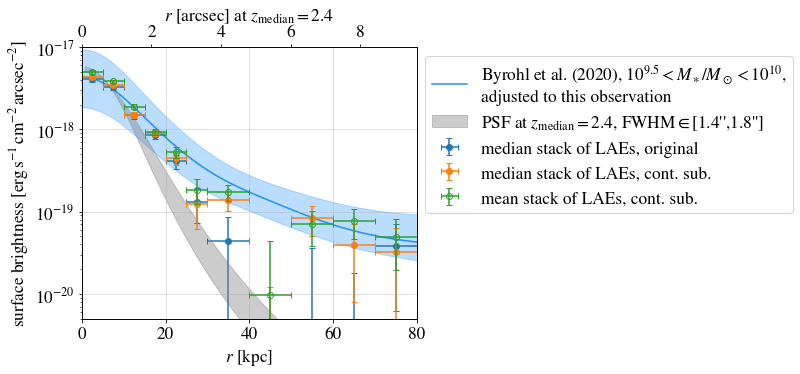

In [31]:
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.errorbar(r_bins_plot, stack_median*10**(-17), yerr=stack_median_error*10**(-17), xerr=delta_r_kpc,
             fmt="o", label=r"median stack of LAEs, original", capsize=3, zorder=1)
ax1.errorbar(r_bins_plot, stack_median_troughsub*10**(-17), yerr=stack_median_error_troughsub*10**(-17), xerr=delta_r_kpc,
             fmt="o", label=r"median stack of LAEs, cont. sub.", capsize=3, zorder=2)
ax1.errorbar(r_bins_plot, stack_mean_troughsub*10**(-17), yerr=stack_mean_error_troughsub*10**(-17), xerr=delta_r_kpc, 
             fmt="o", mfc='none', label=r"mean stack of LAEs, cont. sub.", capsize=3, zorder=3)

if True:
    color='dodgerblue'
    ax1.plot(chris_model_stack["r"]*kpc_per_arcsec_mid, chris_model_stack["total_total"], color=color,
             label=r"""Byrohl et al. (2020), $10^{9.5} < M_\ast /M_\odot < 10^{10}$,
adjusted to this observation""", zorder=0)
    ax1.fill_between(chris_model_stack["r"]*kpc_per_arcsec_mid, chris_model_stack["total_total_16"], 
                     chris_model_stack["total_total_84"], color=color, alpha=0.3, zorder=0)
    

#plt.plot(r_psf*kpc_per_arcsec_mid, psf_mid/psf_mid_integral*stack_median_integral*10**(-17), color="tab:green")
ax1.fill_between(r_psf*kpc_per_arcsec_mid, psf_min/psf_min_integral*stack_median_integral*10**(-17), psf_max/psf_max_integral*stack_median_integral*10**(-17),
                 color="gray", alpha=0.4, label=r"PSF at $z_\mathrm{median}=2.4$, FWHM$\in$[1.4'',1.8'']")

if False:
    ax1.plot(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=median_c1s, c2=median_c2s, redshift=2.4),
            color="deepskyblue", label=r"""median of individual LAEs, original""")
    ax1.fill_between(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=median_c1s-median_c1s_err, 
                                                                              c2=median_c2s-median_c2s_err, redshift=2.4),
                     10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=median_c1s+median_c1s_err, c2=median_c2s+median_c2s_err, redshift=2.4), 
                     color="deepskyblue", alpha=0.3)

    ax1.plot(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=mid_all_c1, c2=mid_all_c2, redshift=2.4),
            color="tab:red", label=r"""all LAEs, original, $\sigma_\mathrm{int}=0$""")
    ax1.fill_between(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=min_all_c1, c2=mid_all_c2, redshift=2.4),
                     10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=max_all_c1, c2=max_all_c2, redshift=2.4), color="tab:red", alpha=0.4)

    ax1.plot(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=mid_all_c1_s, c2=mid_all_c2_s, redshift=2.4),
            color="tab:purple", label=r"""all LAEs, original, $\sigma_\mathrm{int}\neq 0$""")
    ax1.fill_between(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=min_all_c1_s, c2=mid_all_c2_s, redshift=2.4),
                     10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=max_all_c1_s, c2=max_all_c2_s, redshift=2.4), color="tab:purple", alpha=0.3)

    ax1.plot(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.5, c2=0.06, redshift=2.4),
            color="limegreen", label=r"""median of individual LAEs, cont. sub.""")
    ax1.fill_between(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.3, c2=0.04, redshift=2.4),
                     10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.7, c2=0.08, redshift=2.4), color="limegreen", alpha=0.3)


    ax1.plot(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.84, c2=-0.061, redshift=2.4),
            color="hotpink", label=r"""all LAEs, cont. sub., $\sigma_\mathrm{int}=0$""")
    ax1.fill_between(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.79, c2=-0.065, redshift=2.4),
                     10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.89, c2=-0.057, redshift=2.4), color="hotpink", alpha=0.3)

    ax1.plot(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.38, c2=0.15, redshift=2.4),
            color="mediumblue", label=r"""all LAEs, cont. sub., $\sigma_\mathrm{int}\neq 0$""")
    ax1.fill_between(r_psf*kpc_per_arcsec_mid, 10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.28, c2=0.14, redshift=2.4),
                     10**(-17)*lae_profile_powerlaw(r_psf, fwhm_mean, c1=1.47, c2=0.16, redshift=2.4), color="mediumblue", alpha=0.3)

ax1.grid(alpha=0.5)
ax1.set_yscale("log")
ax1.set_xlim(0, 80)
ax1.set_ylim(5e-21, 1e-17)
ax1.legend(bbox_to_anchor=[1,1.], loc='upper left')#, title='core + powerlaw profile', title_fontsize='xx-large')
ax1.set_xlabel(r"$r$ [kpc]")
ax1.set_ylabel(r"surface brightness [$\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}$]")

ax2.set_xlim(ax1.get_xlim())
new_tick_locations = np.arange(0,10,2)*(kpc_per_arcsec_mid)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([0, 2, 4, 6, 8])
ax2.set_xlabel(r"$r$ [arcsec] at $z_\mathrm{median}=2.4$")

#fig.savefig("thesis_plots/stack_lowfwhm_compare_chris_profile.pdf", bbox_inches="tight")

In [78]:
np.nanmedian(lae_info['wl_com']/1215.67-1)

2.383623845286961

# analyze simulated LAEs

In [89]:
sim_prof_dir = "../gama09/lae_simulated/"
sim_tabs = {}
for fin in glob.glob(sim_prof_dir+"g*"):
    lae_id = fin.split("/")[-1][:-4]
    sim_tabs[lae_id] = ascii.read(fin)

In [128]:
sim_dir = "../gama09/cobaya-chains/simulated_LAEs/original/" #troughsub/" #
sim_chains = {}
bigff = glob.glob(sim_dir+"g*")
N = len(bigff)
i=0
for ff in bigff:
    key = ff.split("/")[-1]
    chains = []
    for fin in glob.glob(ff+"/*.?.txt"):
        tmp = ascii.read(fin)
        chains.append(tmp[int(len(tmp)/3.):])
    if len(chains)==0:
        continue
    sim_chains[key] = vstack(chains)
    i+=1
    if i%100==0:
        print(f"Finished {i}/{N}.")

Finished 100/990.
Finished 200/990.
Finished 300/990.
Finished 400/990.
Finished 500/990.
Finished 600/990.
Finished 700/990.
Finished 800/990.
Finished 900/990.


In [129]:
c1s_min_sim, c1s_max_sim, c1s_mid_sim = [np.nanpercentile(mc["c1"], 16) for mc  in sim_chains.values()], [np.nanpercentile(mc["c1"], 100-16) for mc  in sim_chains.values()], [np.nanmedian(mc["c1"]) for mc  in sim_chains.values()]
c2s_min_sim, c2s_max_sim, c2s_mid_sim = [np.nanpercentile(mc["c2"], 16) for mc  in sim_chains.values()], [np.nanpercentile(mc["c2"], 100-16) for mc  in sim_chains.values()], [np.nanmedian(mc["c2"]) for mc  in sim_chains.values()]

c1s_min_sim, c1s_max_sim, c1s_mid_sim = np.array(c1s_min_sim), np.array(c1s_max_sim), np.array(c1s_mid_sim)
c2s_min_sim, c2s_max_sim, c2s_mid_sim = np.array(c2s_min_sim), np.array(c2s_max_sim), np.array(c2s_mid_sim)

median_c1s_sim = np.nanmedian(c1s_mid_sim)
median_c1s_err_sim = np.nanstd(c1s_mid_sim)/np.sqrt(len(c1s_mid_sim))
median_c2s_sim = np.nanmedian(c2s_mid_sim)
median_c2s_err_sim = np.nanstd(c2s_mid_sim)/np.sqrt(len(c2s_mid_sim))

mean_c1s_sim = np.nanmean(c1s_mid_sim)
mean_c1s_err_sim = np.nanstd(c1s_mid_sim)/np.sqrt(len(c1s_mid_sim))
mean_c2s_sim = np.nanmean(c2s_mid_sim)
mean_c2s_err_sim = np.nanstd(c2s_mid_sim)/np.sqrt(len(c2s_mid_sim))


In [130]:
keys_array = np.array(list(sim_chains.keys()))
print(len(keys_array))
here_zeros = np.array([key.split("_")[1]=="0" for key in keys_array])
here_ofives =np.array([key.split("_")[1]=="5" for key in keys_array])
here_ones =np.array([key.split("_")[1]=="10" for key in keys_array])
here_twos =np.array([key.split("_")[1]=="20" for key in keys_array])
here_fives =np.array([key.split("_")[1]=="50" for key in keys_array])
print(len(keys_array[here_zeros])+len(keys_array[here_ofives])+len(keys_array[here_ones])+len(keys_array[here_twos])+len(keys_array[here_fives]))

990
990


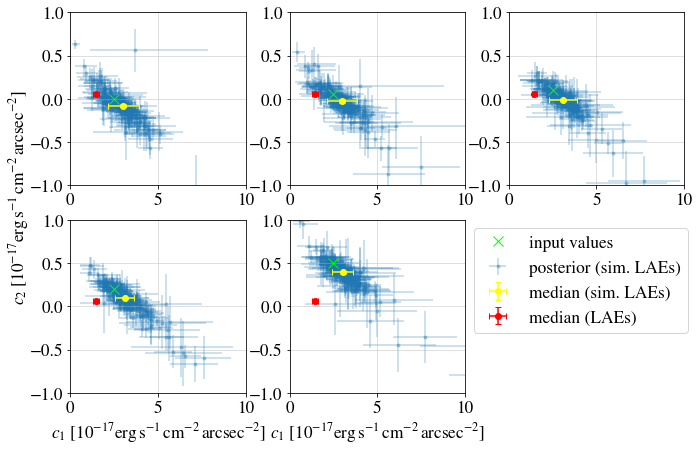

In [132]:
fig = plt.figure(figsize=(11,7))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232, sharey=ax1)
ax3 = fig.add_subplot(233, sharey=ax2)
ax4 = fig.add_subplot(234, sharex=ax1)
ax5 = fig.add_subplot(235, sharex=ax2, sharey=ax4)

for ax, value, mask in zip([ax1, ax2, ax3, ax4, ax5], [0, 0.05, 0.1, 0.2, 0.5], [here_zeros, here_ofives, here_ones, here_twos, here_fives]):
    ax.plot(2.5, value, "x", color="lime", zorder=4, markersize=10, label="input values") # color='lime'
    #mask *= c1s_mid_sim < 10
    ax.errorbar(c1s_mid_sim[mask], c2s_mid_sim[mask], xerr=[c1s_mid_sim[mask]-c1s_min_sim[mask], c1s_max_sim[mask]-c1s_mid_sim[mask]],
                     yerr=[c2s_mid_sim[mask]-c2s_min_sim[mask], c2s_max_sim[mask]-c2s_mid_sim[mask]], fmt=".", 
                     color="tab:blue", alpha=0.3, zorder=0, label="posterior (sim. LAEs)")
    c1s_median_sim = np.nanmedian(c1s_mid_sim[mask])
    c1s_median_error_sim = np.nanstd(c1s_mid_sim[mask])/np.sqrt(len(mask[mask]))
    c2s_median_sim = np.nanmedian(c2s_mid_sim[mask])
    c2s_median_error_sim = np.nanstd(c2s_mid_sim[mask])/np.sqrt(len(mask[mask]))
    ax.errorbar(c1s_median_sim, c2s_median_sim, xerr=c1s_median_error_sim, yerr=c2s_median_error_sim, color="yellow", zorder=2, capsize=3, fmt="o", label="median (sim. LAEs)")
    ax.errorbar(median_c1s, median_c2s, xerr=median_c1s_err, yerr=median_c2s_err,
             fmt="o", color="red", label="median (LAEs)", capsize=3, zorder=3)
    #ax.errorbar(c1s_mid, c2s_mid, xerr=[c1s_mid-c1s_min, c1s_max-c1s_mid], yerr=[c2s_mid-c2s_min, c2s_max-c2s_mid], fmt=".", color="tab:orange", label=r"individual LAEs", alpha=0.2)
    #ax.set_title(r"$c_1=2.5$, $c_2={}$".format(value))
    ax.grid(alpha=0.5)
    ax.set_xlim(0, 10)
    ax.set_ylim(-1, 1)
    
for ax in [ax4, ax5]:
    ax.set_xlabel(r"$c_1\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$")
for ax in [ax1]:#, ax4]:
    ax.text(-3.6, -2.3, r"$c_2\,\, [10^{-17}\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}]$", fontsize='xx-large', rotation=90)

ax5.legend(bbox_to_anchor=(1.,1), loc='upper left', facecolor='white')#, title='local continuum subtraction', title_fontsize='xx-large')

plt.subplots_adjust(wspace=0.25, hspace=0.2)

#fig.savefig("thesis_plots/gama_simulated_laes_posterior.pdf", bbox_inches="tight")

# compare $\sigma_\mathrm{int}$ with surface brightness errors

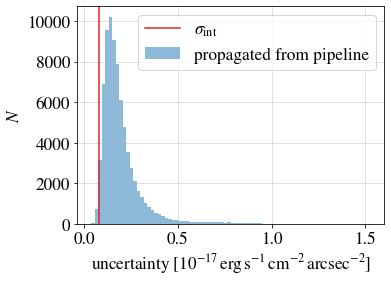

In [340]:
plt.figure(figsize=(5.5,4))
plt.hist(np.concatenate([lae_tabs[key]['flux_error'][lae_tabs[key]['mask']] for key in lae_tabs.keys()])/fiberarea, bins=80, alpha=0.5, density=False, label="""propagated from pipeline""")
#plt.hist(np.concatenate([lae_tabs[key]['flux_troughsub_error'] for key in lae_tabs.keys()])/fiberarea, bins=20, alpha=0.5, density=False);

plt.axvline(0.082, color='tab:red', label='$\sigma_\mathrm{int}$')

plt.xlabel(r'uncertainty [$10^{-17}\,\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{arcsec}^{-2}$]')
plt.ylabel(r'$N$')
plt.grid(alpha=0.5)
#plt.yscale('log')
plt.legend()

#plt.savefig('thesis_plots/suface_brightness_errors_vs_sigma_int.pdf', bbox_inches='tight')

# look at each individual LAE fit

In [473]:
megachains2 = {}
for ff in glob.glob(f"../gama09/cobaya-chains/LAEs_individual/original/"+"g*"):
    fin = glob.glob(ff+"/*.?.txt")
    if len(fin)==0:
        print(ff, " is empty.")
        continue
    chains = []
    for fi in fin:
        tmp = ascii.read(fi)
        chains.append(tmp[int(len(tmp)/3.):])
    megachains2[ff.split("/")[-1]] = vstack(chains)

In [487]:
if False:
    for key in list(lae_tabs.keys())[:]:
        plt.figure(figsize=(10,4))
        tmp = lae_tabs[key]
        plt.errorbar(tmp['r'], tmp['flux_troughsub']/fiberarea, yerr=tmp['flux_troughsub_error']/fiberarea, fmt='.', capsize=3, zorder=0)
        plt.errorbar(tmp['r'][tmp['mask']==1], tmp['flux'][tmp['mask']==1]/fiberarea, yerr=tmp['flux_error'][tmp['mask']==1]/fiberarea, capsize=3, fmt='.', zorder=0)
        c1 = np.nanmedian(megachains[key]['c1'])
        c2 = np.nanmedian(megachains[key]['c2'])
        plt.plot(r_psf, lae_profile_powerlaw(r_psf, fwhm_mean, c1=c1, c2=c2, redshift=2.3), label='troughsub')
        c1 = np.nanmedian(megachains2[key]['c1'])
        c2 = np.nanmedian(megachains2[key]['c2'])
        plt.plot(r_psf, lae_profile_powerlaw(r_psf, fwhm_mean, c1=c1, c2=c2, redshift=2.3), label='original')
        plt.xlim(0, 10)

0.009013455361127853

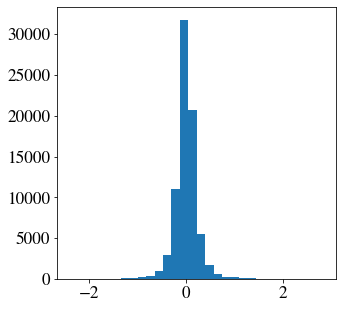

In [484]:
plt.figure(figsize=(5,5))
plt.hist(np.concatenate([lae_tabs[key]['flux_troughsub'][lae_tabs[key]['mask']==1] - lae_tabs[key]['flux'][lae_tabs[key]['mask']==1] for key in lae_tabs.keys()]), bins=30);
np.nanmedian(np.concatenate([lae_tabs[key]['flux_troughsub'][lae_tabs[key]['mask']==1] - lae_tabs[key]['flux'][lae_tabs[key]['mask']==1] for key in lae_tabs.keys()]))

# FWHM plots

In [13]:
from gama_tools import *
config = GamaConfig()
print(config.survey)
survey_tab = ascii.read(config.survey)
my_fwhm = ascii.read("fwhm_posterior_mean.tab")
fwhm_post = ascii.read('fwhm_posterior.tab')

/home/idies/workspace/Temporary/maja/scratch/gama09/survey.tab


Text(0, 0.5, "posterior mean FWHM ['']")

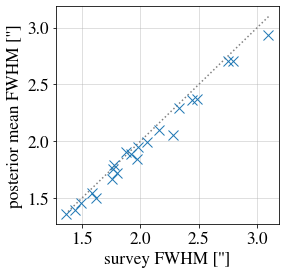

In [14]:
plt.figure(figsize=(4,4))
ratios = []
for shot in np.unique(my_fwhm['shotid']):
    shotid = shot[5:]
    try:
        tmp = fwhm_post[fwhm_post['shotid']==shot]
        cum_post = np.array([np.sum(tmp['post'][:i+1]) for i in range(len(tmp))])/np.sum(tmp['post'])

        perc_16 = tmp['fwhm'][(cum_post>=0.16)][0]
        perc_84 = tmp['fwhm'][(cum_post>=0.84)][0]

        error = (perc_84 - perc_16)/2
    except:
        error = 0
    
    plt.errorbar(np.nanmean(survey_tab["fwhm"][survey_tab["shotid"]==shot]), my_fwhm["fwhm"][my_fwhm["shotid"]==shot][0], 
                yerr = error,
                 fmt="x", color="tab:blue", markersize=10)
    x, y = np.nanmean(survey_tab["fwhm"][survey_tab["shotid"]==shot]), my_fwhm["fwhm"][my_fwhm["shotid"]==shot][0]
    
    ratios.append((x-y)/x)
    
plt.plot([1.38, 3.1], [1.38, 3.1], color='gray', linestyle=':')
plt.grid(alpha=0.5)
plt.xlabel("survey FWHM ['']")
plt.ylabel("posterior mean FWHM ['']")

#plt.savefig('thesis_plots/fwhm_survey_vs_own.pdf', bbox_inches='tight')